In [1]:
#import GPy
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt
import sklearn 

from sklearn.decomposition import PCA
from numpy.linalg import inv
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

import uncertainty_toolbox as uct

from sklearn.model_selection import train_test_split



import emcee
import ptemcee
import h5py
from scipy.linalg import lapack
from multiprocessing import Pool
from multiprocessing import cpu_count

sns.set("notebook")

In [2]:
#Saved emulator name
EMU='PbPb2760_emulators_scikit.dat'

In [3]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

In [4]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

In [5]:
# Design points
design = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_design")

In [6]:
#Simulation outputs at the design points
simulation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_simulation_0")

In [7]:
X = design.values
Y = simulation.values

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)


In [9]:
X= X_train
Y= Y_train

In [10]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (378, 17)
Y.shape : (378, 110)


In [11]:
#Model parameter names in Latex compatble form
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$\\sigma_k$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\tau_R$ [fm/$c$]',
 '$\\alpha$',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$b_{\\pi}$',
 '$T_{\\mathrm{sw}}$ [GeV]']

In [12]:
#Scaling the data to be zero mean and unit variance for each feature
SS  =  StandardScaler(copy=True)

In [13]:
#Singular Value decomposition
u, s, vh = np.linalg.svd(SS.fit_transform(Y), full_matrices=True)
print(f'shape of u {u.shape} shape of s {s.shape} shape of vh {vh.shape}')

shape of u (378, 378) shape of s (110,) shape of vh (110, 110)


In [14]:
#whiten and project data to principal component axis (only keeping first 10 PCs)
pc_tf_data=u[:,0:10] * math.sqrt(u.shape[0]-1)
#Scale Transformation from PC space to original data space
inverse_tf_matrix= np.diag(s[0:10]) @ vh[0:10,:] * SS.scale_.reshape(1,110)/ math.sqrt(u.shape[0]-1)

In [15]:
# White actually multiply each PC by sqrt of n_samples-1
pca_analysis = PCA(n_components=10, whiten=True, svd_solver='auto')
pca_analysis.fit(SS.fit_transform(Y))
scikit_pc_tf_data=pca_analysis.transform(SS.fit_transform(Y))
print(f'Transformed data shape {scikit_pc_tf_data.shape}')

Transformed data shape (378, 10)


In [16]:
#The sign difference is OK. That is why we only compare abs value of transformed Data
#explanation https://stackoverflow.com/questions/44765682/in-sklearn-decomposition-pca-why-are-components-negative
print(f'Print True if the transformed data is same from SVD aproach and scikit\
learn PCA methods\n{np.allclose(np.abs(scikit_pc_tf_data),np.abs(pc_tf_data))}')

Print True if the transformed data is same from SVD aproach and scikitlearn PCA methods
True


In [17]:
scikit_inverse_tf_data=SS.inverse_transform(pca_analysis.inverse_transform(scikit_pc_tf_data))
inverse_tf_data=pc_tf_data @ inverse_tf_matrix + np.repeat([SS.mean_],repeats=378, axis=0)
print(f'Print True if the inverse transformed data is same from SVD aproach and scikit\
learn PCA methods\n{np.allclose(scikit_inverse_tf_data,inverse_tf_data)}')

Print True if the inverse transformed data is same from SVD aproach and scikitlearn PCA methods
True


In [18]:
# Bounds for parametrs in the emulator are same as prior ranges so
prior_df = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_prior", index_col=0)

In [19]:
design_max=prior_df.loc['max'].values
design_min=prior_df.loc['min'].values

In [30]:
prior_df

,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
min,10.0,-0.7,0.3,0.5,0.000,0.3,-0.3,0.13,-2.0,-1.0,0.01,0.01,0.12,0.025,-0.8,2.0,0.130
max,20.0,0.7,2.0,1.5,4.913,2.0,0.3,0.30,1.0,2.0,0.20,0.20,0.30,0.150,0.8,8.0,0.165


In [20]:
import time
design=X
overide=True
input_dim=len(design_max)
ptp = design_max - design_min
bound=zip(design_min,design_max)
if (os.path.exists(data_path(EMU))) and (overide==False):
    print('Saved emulators exists and overide is prohibited')
    with open(data_path(EMU),"rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators=[]
    for i in range(0,10):
        start_time = time.time()
        kernel=1*krnl.RBF(length_scale=ptp,length_scale_bounds=np.outer(ptp, (4e-1, 1e2)))+ krnl.WhiteKernel(noise_level=.1, noise_level_bounds=(1e-2, 1e2))#+krnl.ConstantKernel()
        GPR=gpr(kernel=kernel,n_restarts_optimizer=4,alpha=0.0000000001)
        GPR.fit(design,pc_tf_data[:,i].reshape(-1,1))
        print(f'GPR score is {GPR.score(design,pc_tf_data[:,i])} \n')
        print(f'GP length scales {GPR.kernel_}')
        #print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} \n')
        print("--- %s seconds ---" % (time.time() - start_time))
        Emulators.append(GPR)

if (overide==True) or not(os.path.exists(data_path(EMU))):
    with open(data_path(EMU),"wb") as f:
        pickle.dump(Emulators,f)

GPR score is 0.9854979630173542 

GP length scales 2.49**2 * RBF(length_scale=[24.7, 2.26, 4.63, 2.69, 83.6, 3.8, 4.34, 0.428, 9.37, 6.86, 0.589, 0.525, 0.429, 1.85, 4.88, 132, 0.184]) + WhiteKernel(noise_level=0.0232)
--- 11.73623013496399 seconds ---
GPR score is 0.9941153647787763 

GP length scales 2.82**2 * RBF(length_scale=[31.1, 5.97, 8.78, 2.65, 152, 3.58, 1.72, 2.14, 53.2, 10.7, 0.685, 0.288, 0.156, 0.589, 3.16, 313, 0.0894]) + WhiteKernel(noise_level=0.0118)
--- 16.713319063186646 seconds ---
GPR score is 0.9950713865680801 

GP length scales 1.77**2 * RBF(length_scale=[20.6, 3.01, 2.95, 1.66, 40.2, 2.32, 1.49, 0.185, 4.34, 6.81, 0.331, 0.318, 0.196, 0.192, 2.91, 28, 0.079]) + WhiteKernel(noise_level=0.017)
--- 12.392199277877808 seconds ---
GPR score is 0.9917284327985851 

GP length scales 2.11**2 * RBF(length_scale=[84.8, 2.87, 2.76, 1.04, 27.6, 1.96, 0.66, 0.265, 5.78, 7.96, 0.267, 1.81, 1.28, 12.5, 33.6, 30.2, 0.0791]) + WhiteKernel(noise_level=0.0185)
--- 18.64505100250

In [21]:
def predict_observables(model_parameters):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values. Should be an 1D array of 17 model parametrs.
    Return
    ------
    Mean value and full error covaraiance matrix of the prediction is returened. """
    
    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    
    if len(theta)!=17:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,17)
        for i in range(0,10):
            mn,std=Emulators[i].predict(theta,return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean=mean @ inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)
    variance_matrix=np.diag(np.array(variance).flatten())
    A_p=np.abs(inverse_tf_matrix)
    inverse_transformed_variance=np.einsum('ik,kl,lj-> ij', A_p.T, variance_matrix, A_p, optimize=False)
    return inverse_transformed_mean, inverse_transformed_variance

In [22]:
# Load testing data

#design_validation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_validation_design")
#validation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_validation_0")

In [23]:
#design_validation.head()

In [24]:
#make predictions for validation daa from trained emulatorsA
prediction_val = []
prediction_sig_val = []
for row in X_test:
    #print(row)
    prediction,pred_cov = predict_observables(row)
    prediction_sig_val.append(np.sqrt(np.diagonal(pred_cov)))
    prediction_val.append(prediction)
prediction_val = np.array(prediction_val).reshape(-1,110)
prediction_sig_val = np.array(prediction_sig_val).reshape(-1,110)

In [25]:
# for ii, obs in enumerate(simulation.keys()):
#     fig, ax = plt.subplots(figsize=(10,10))
#     #metrics = uct.metrics.get_all_metrics(prediction_val[:,i], prediction_sig_val[:,i]\
#     #                     ,validation.values[:,i])
#     #print(metrics)
#     mse = sklearn.metrics.mean_squared_error(validation.values[:,ii]\
#                                       ,prediction_val[:,ii])
#     r = sklearn.metrics.r2_score(validation.values[:,ii]\
#                                       ,prediction_val[:,ii])
#     #print(mse)
    
#     uct.plot_calibration(prediction_val[:,ii], prediction_sig_val[:,ii]\
#                          ,validation.values[:,ii], ax=ax)
#     ax.set_title(obs+f' MSE {mse:.3f} R2 {r:.2f}')

In [26]:
# 8 bins
ALICE_cent_bins = np.array([[0,5],[5,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70]]) 

obs_cent_list = {
'Pb-Pb-2760': {
    'dNch_deta' : ALICE_cent_bins,
    'dET_deta' : np.array([[0, 2.5], [2.5, 5], [5, 7.5], [7.5, 10],
                           [10, 12.5], [12.5, 15], [15, 17.5], [17.5, 20],
                           [20, 22.5], [22.5, 25], [25, 27.5], [27.5, 30],
                           [30, 32.5], [32.5, 35], [35, 37.5], [37.5, 40],
                           [40, 45], [45, 50], [50, 55], [55, 60],
                           [60, 65], [65, 70]]), # 22 bins
    'dN_dy_pion'   : ALICE_cent_bins,
    'dN_dy_kaon'   : ALICE_cent_bins,
    'dN_dy_proton' : ALICE_cent_bins,
    'dN_dy_Lambda' : np.array([[0,5],[5,10],[10,20],[20,40],[40,60]]), # 5 bins
    'dN_dy_Omega'  : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'dN_dy_Xi'     : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'mean_pT_pion'   : ALICE_cent_bins,
    'mean_pT_kaon'   : ALICE_cent_bins,
    'mean_pT_proton' : ALICE_cent_bins,
    'pT_fluct' : np.array([[0,5],[5,10],[10,15],[15,20], [20,25],[25,30],[30,35],[35,40], [40,45],[45,50],[50,55],[55,60]]), #12 bins
    'v22' : ALICE_cent_bins,
    'v32' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    'v42' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    }
}

In [27]:

#### Block 16 #### Please refer to this number in your questions


obs_groups = {'yields' : ['dNch_deta', 'dET_deta', 'dN_dy_pion', 'dN_dy_kaon', 'dN_dy_proton'],
              'mean_pT' : ['mean_pT_pion', 'mean_pT_kaon','mean_pT_proton', ],
              'fluct' : ['pT_fluct'],
              'flows' : ['v22', 'v32', 'v42']}

obs_group_labels = {'yields' : r'$dN_\mathrm{id}/dy_p$, $dN_\mathrm{ch}/d\eta$, $dE_T/d\eta$ [GeV]',
                    'mean_pT' : r'$ \langle p_T \rangle_\mathrm{id}$' + ' [GeV]',
                    'fluct' : r'$\delta p_{T,\mathrm{ch}} / \langle p_T \rangle_\mathrm{ch}$',
                    'flows' : r'$v^{(\mathrm{ch})}_k\{2\} $'}

colors = ['b', 'g', 'r', 'c', 'm', 'tan', 'gray']

obs_tex_labels = {'dNch_deta' : r'$dN_\mathrm{ch}/d\eta$',
                  'dN_dy_pion' : r'$dN_{\pi}/dy_p$',
                  'dN_dy_kaon' : r'$dN_{K}/dy_p$',
                  'dN_dy_proton' : r'$dN_{p}/dy_p$',
                  'dET_deta' : r'$dE_{T}/d\eta$',
                  
                  'mean_pT_proton' : r'$\langle p_T \rangle_p$',
                  'mean_pT_kaon' : r'$\langle p_T \rangle_K$',
                  'mean_pT_pion' : r'$\langle p_T \rangle_\pi$',
                 
                  'pT_fluct' :r'$\delta p_{T,\mathrm{ch}} / \langle p_T \rangle_\mathrm{ch}$',
                  'v22' : r'$v^{(\mathrm{ch})}_2\{2\}$',
                  'v32' : r'$v^{(\mathrm{ch})}_3\{2\}$',
                  'v42' : r'$v^{(\mathrm{ch})}_4\{2\}$'}

In [28]:
#### Block 17 #### Please refer to this number in your questions


index={}
st_index=0
for obs_group in  obs_groups.keys():
    for obs in obs_groups[obs_group]:
        #print(obs)
        n_centrality= len(obs_cent_list['Pb-Pb-2760'][obs])
        #print(n_centrality)
        index[obs]=[st_index,st_index+n_centrality]
        st_index = st_index+n_centrality
print(index)

{'dNch_deta': [0, 8], 'dET_deta': [8, 30], 'dN_dy_pion': [30, 38], 'dN_dy_kaon': [38, 46], 'dN_dy_proton': [46, 54], 'mean_pT_pion': [54, 62], 'mean_pT_kaon': [62, 70], 'mean_pT_proton': [70, 78], 'pT_fluct': [78, 90], 'v22': [90, 98], 'v32': [98, 104], 'v42': [104, 110]}


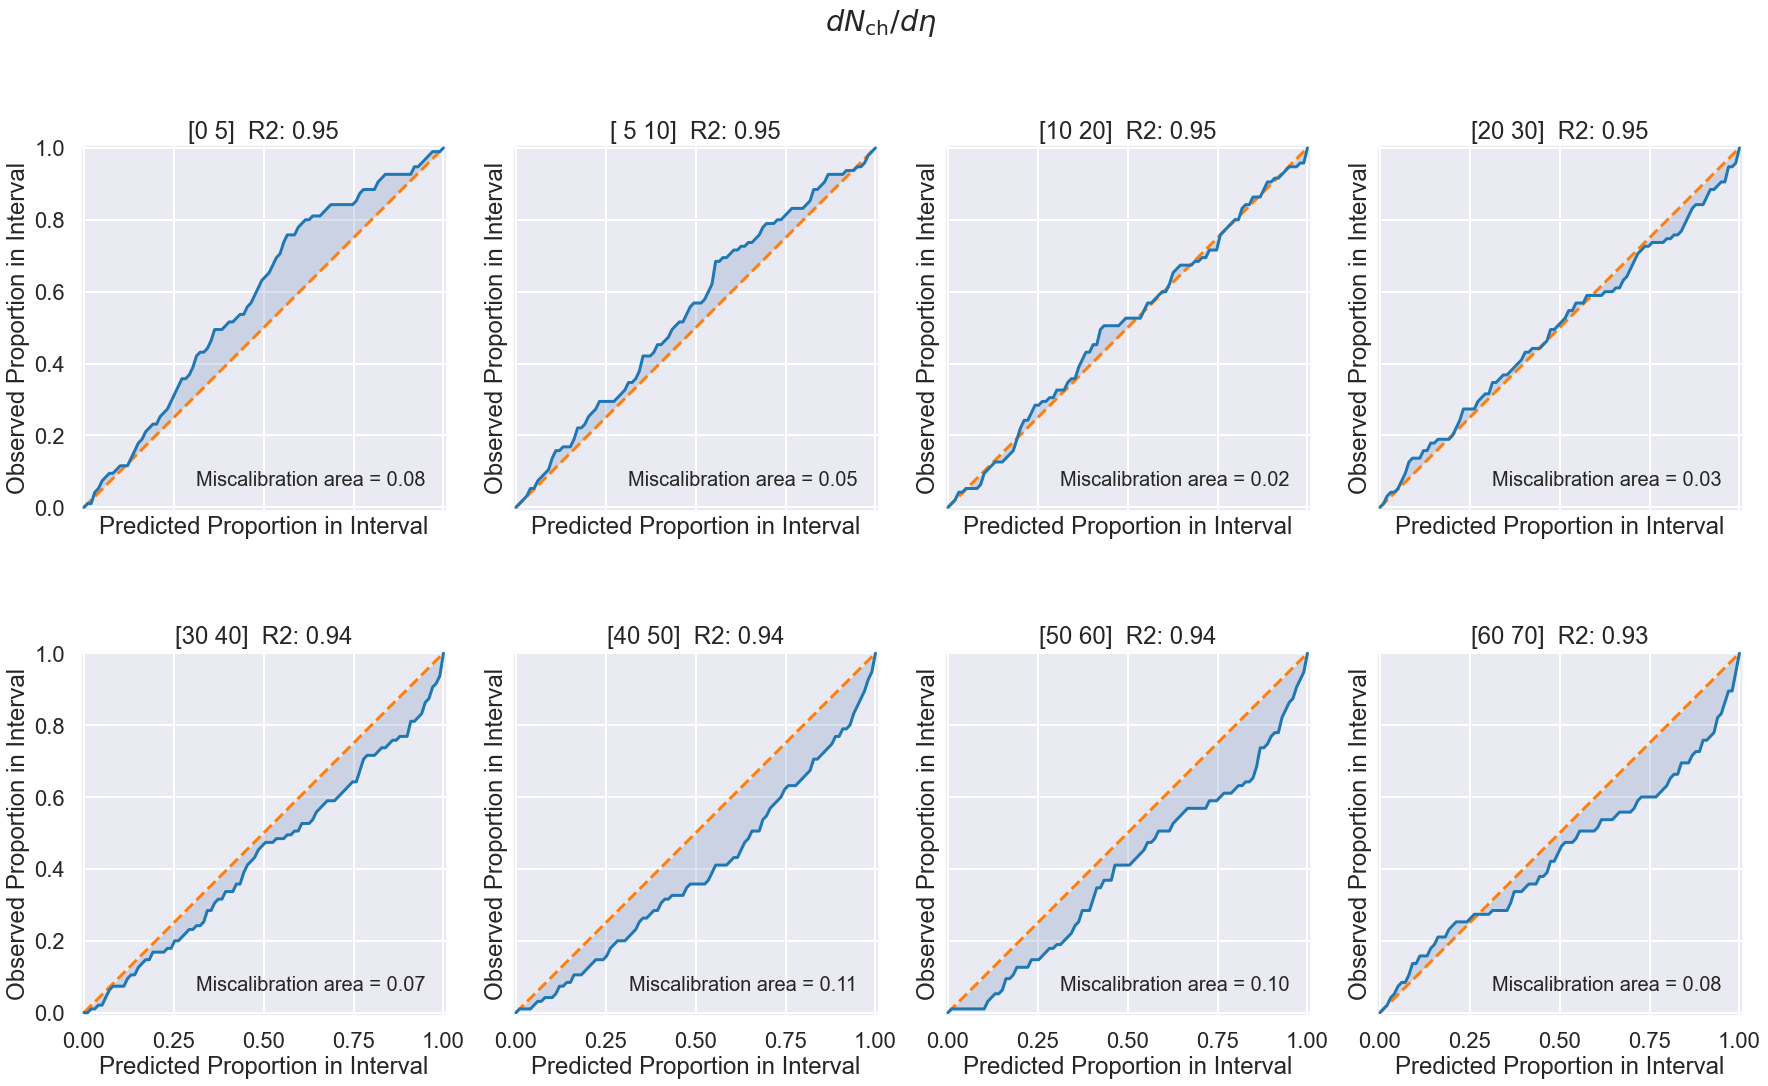

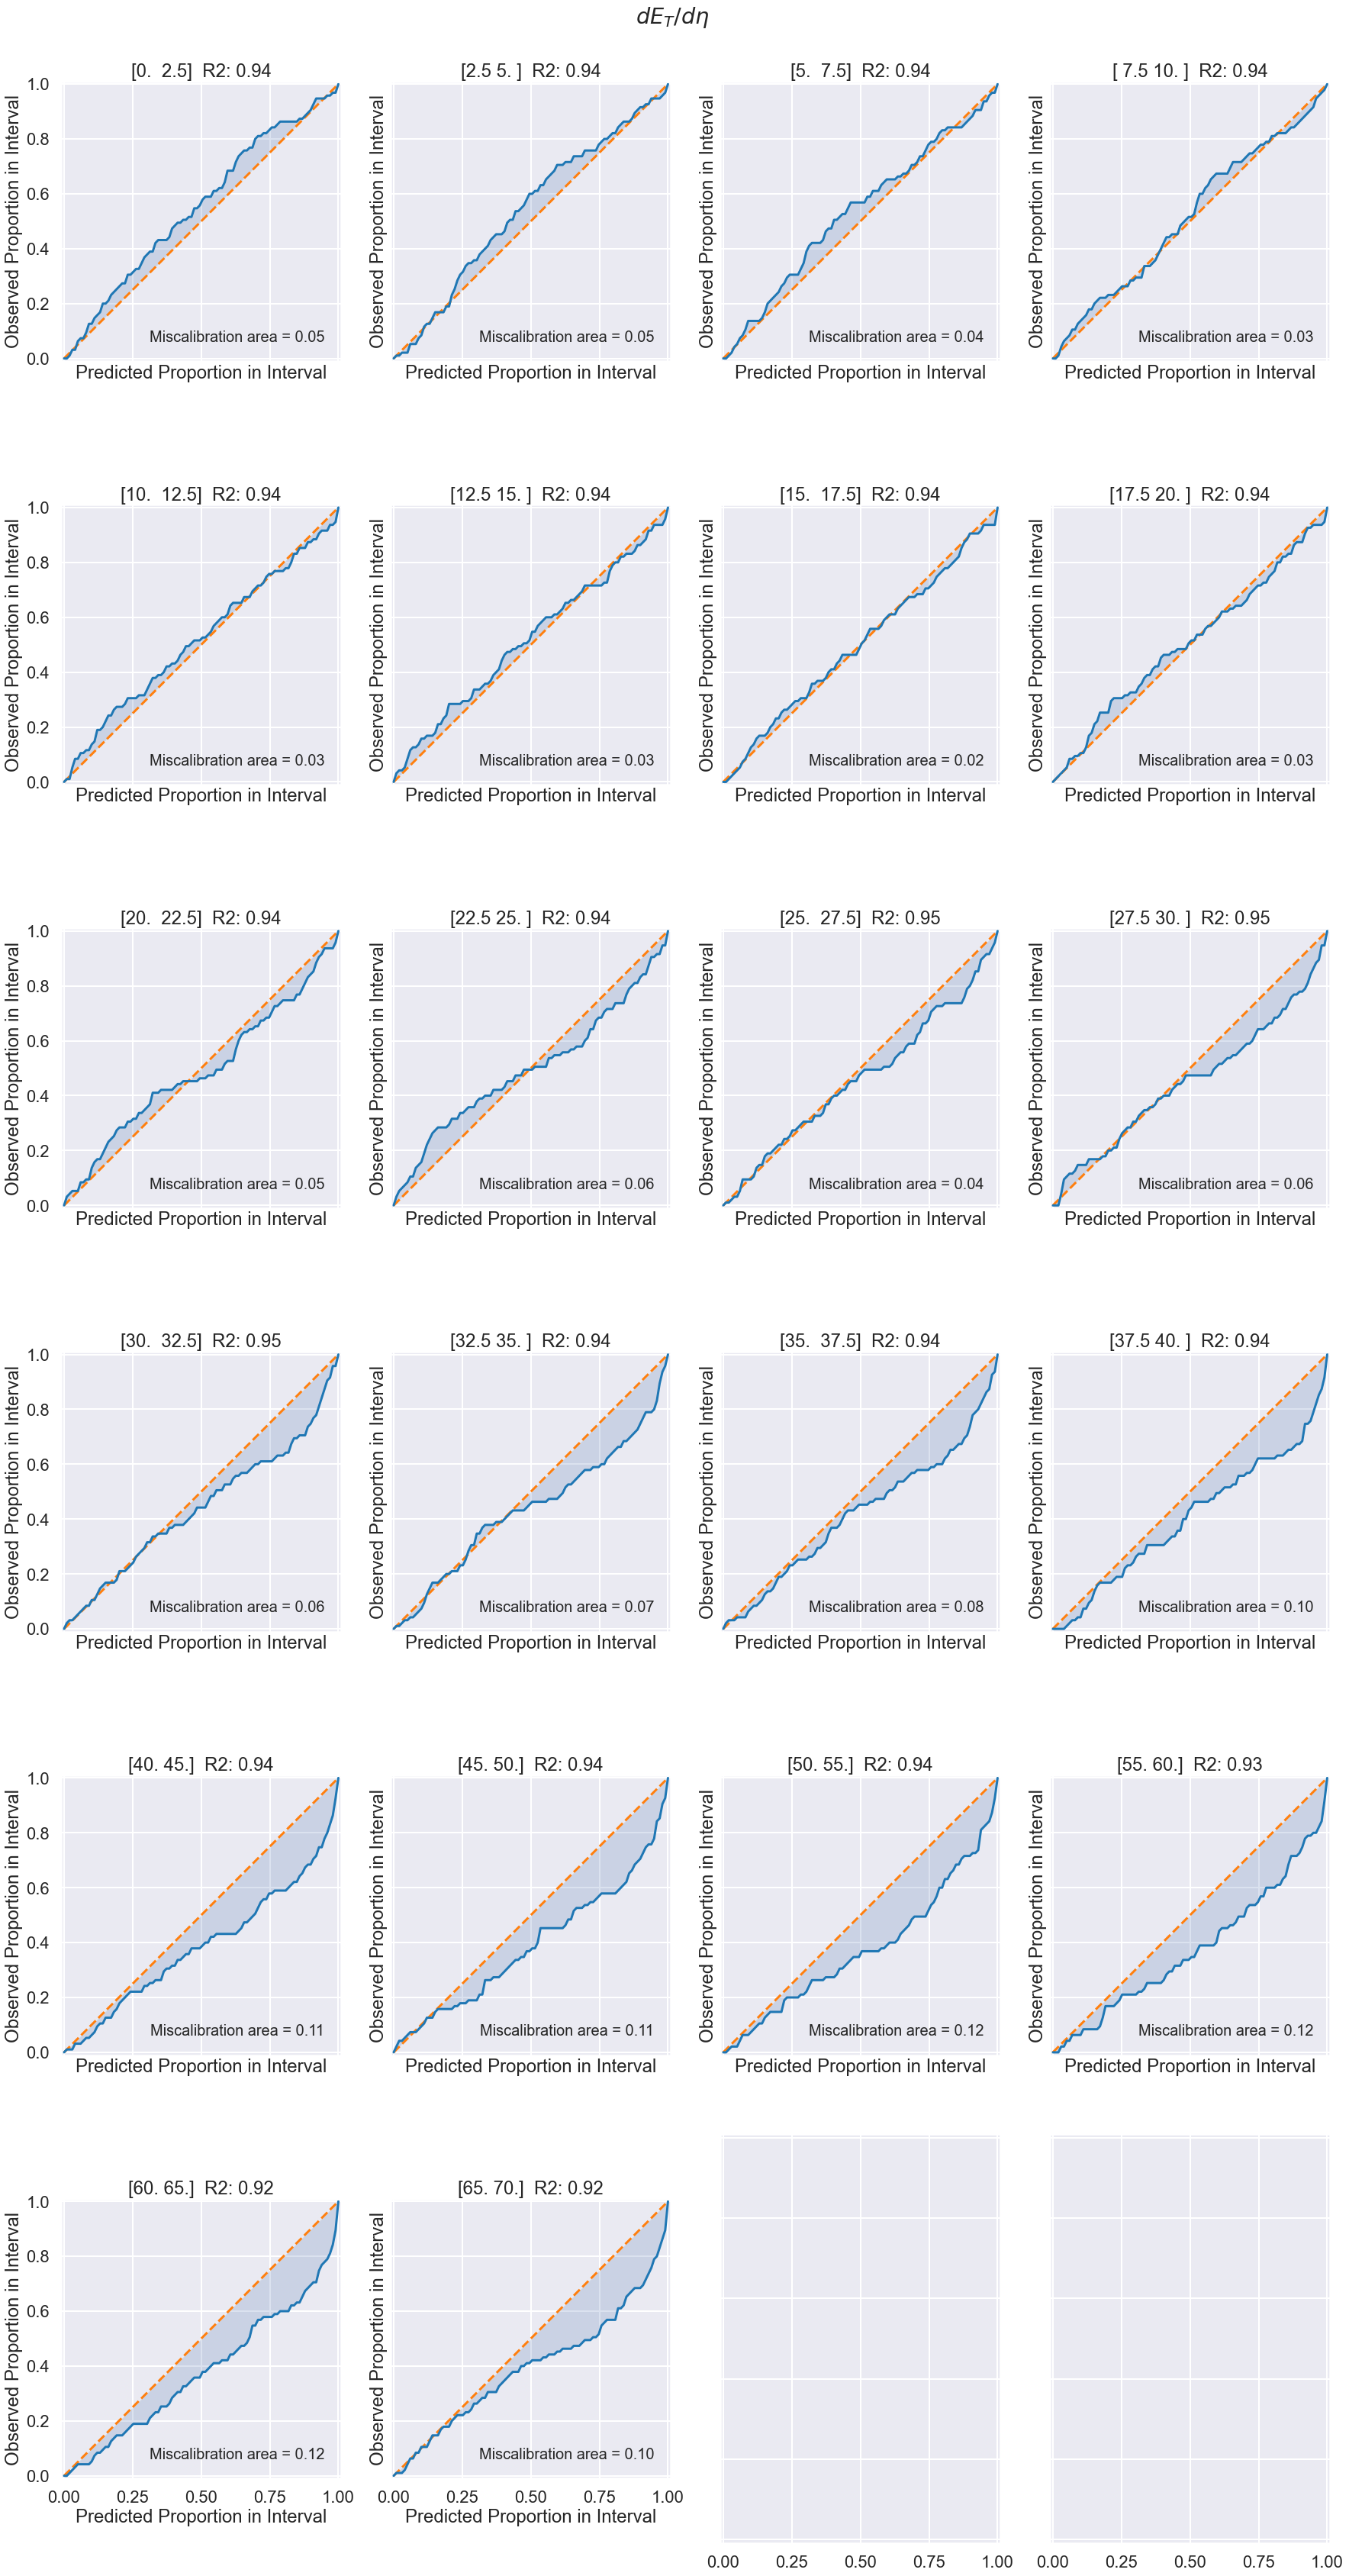

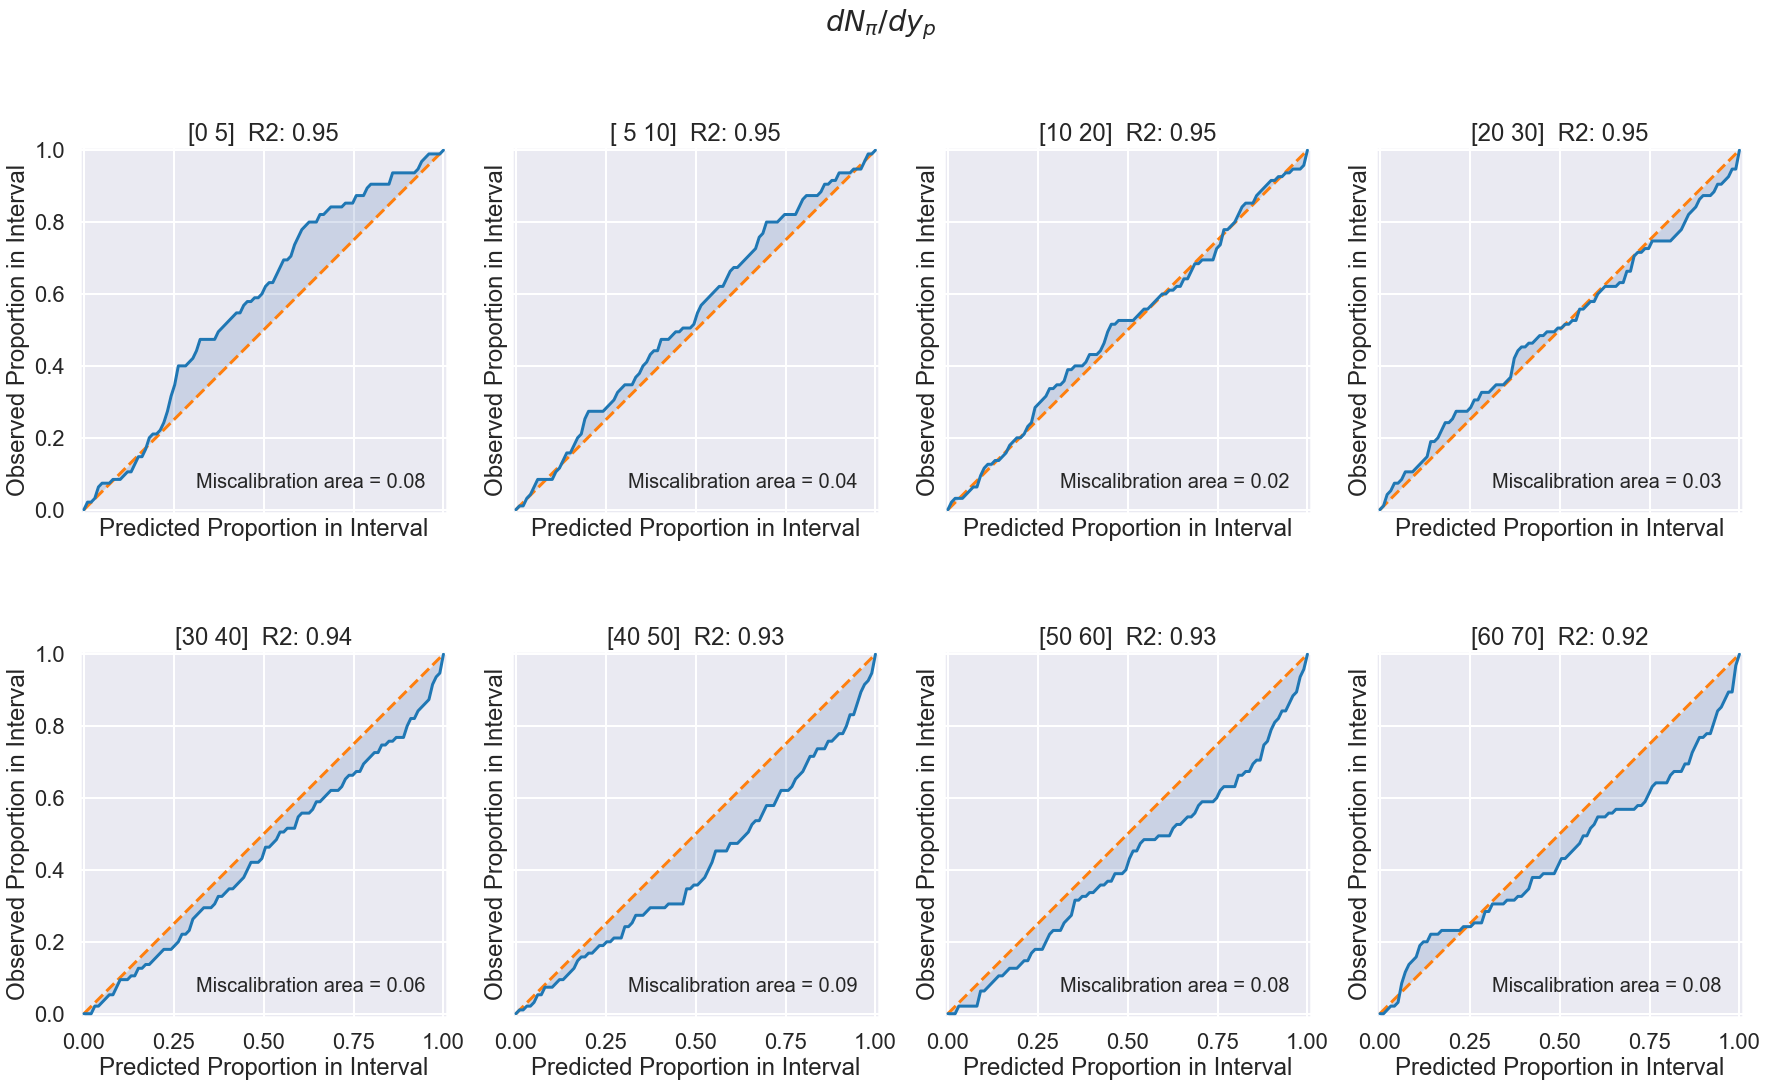

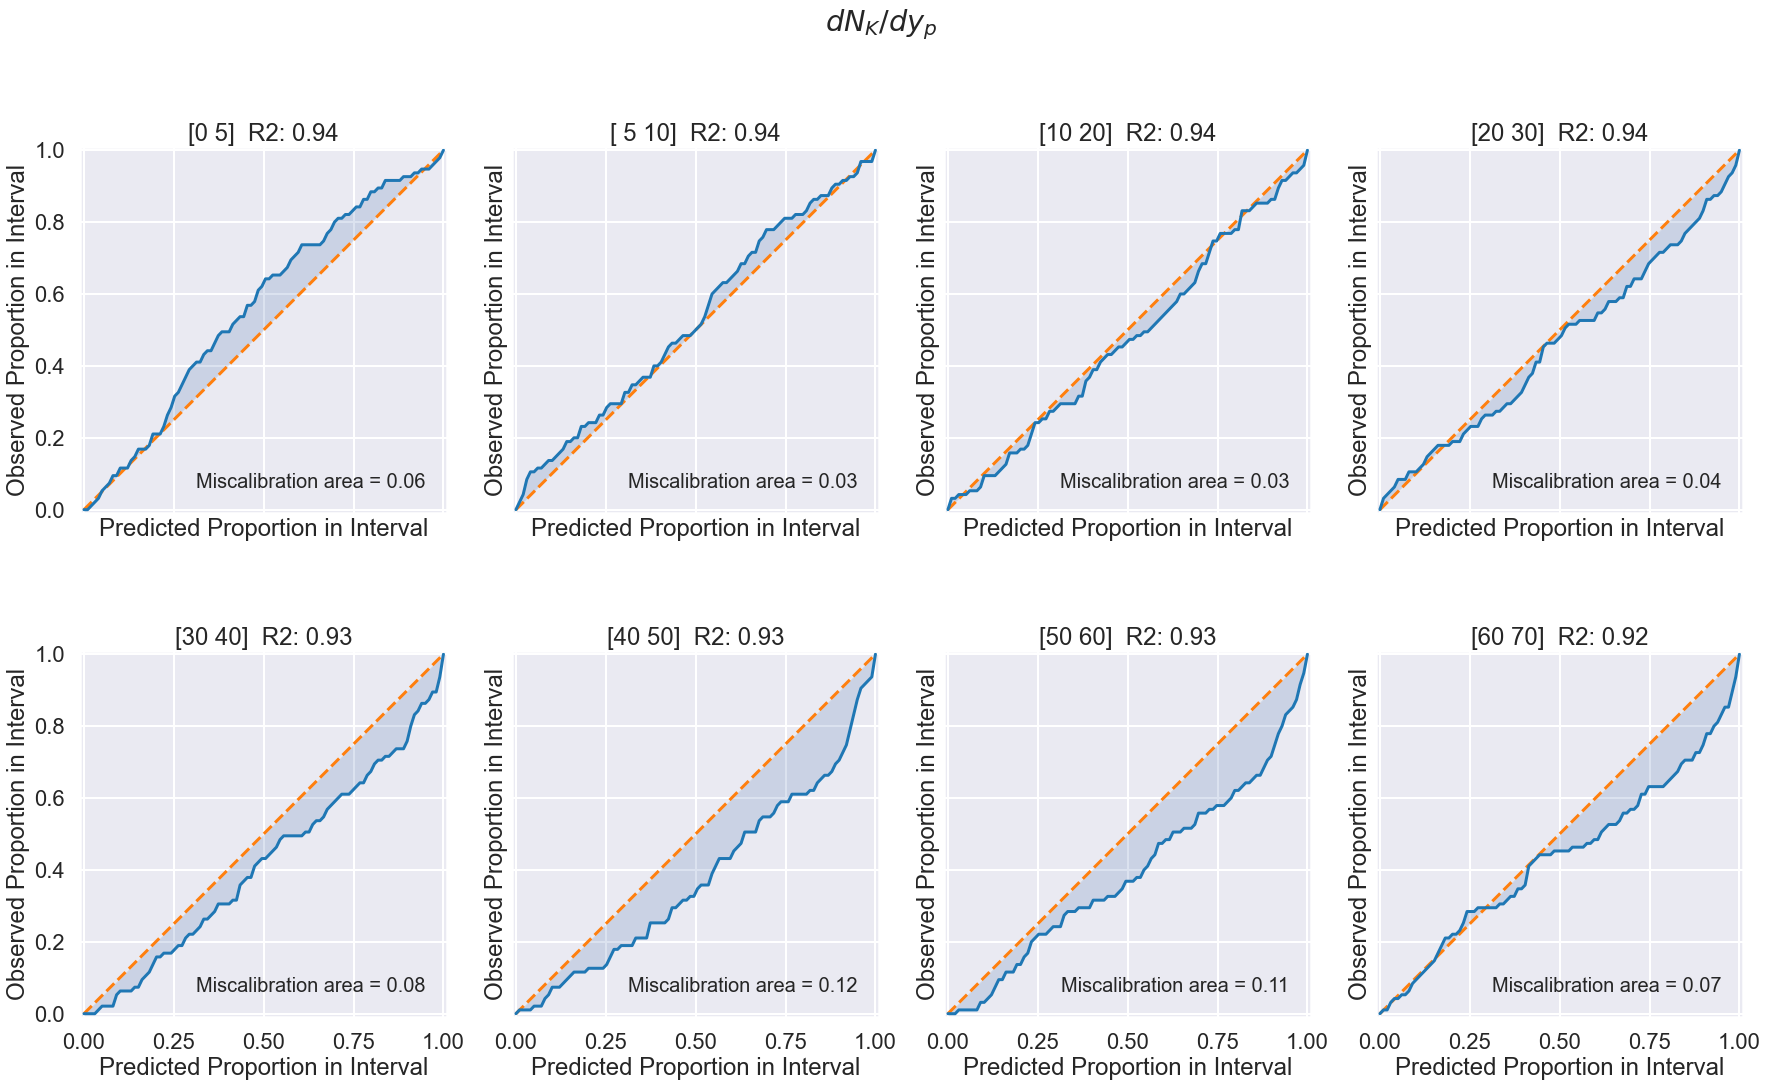

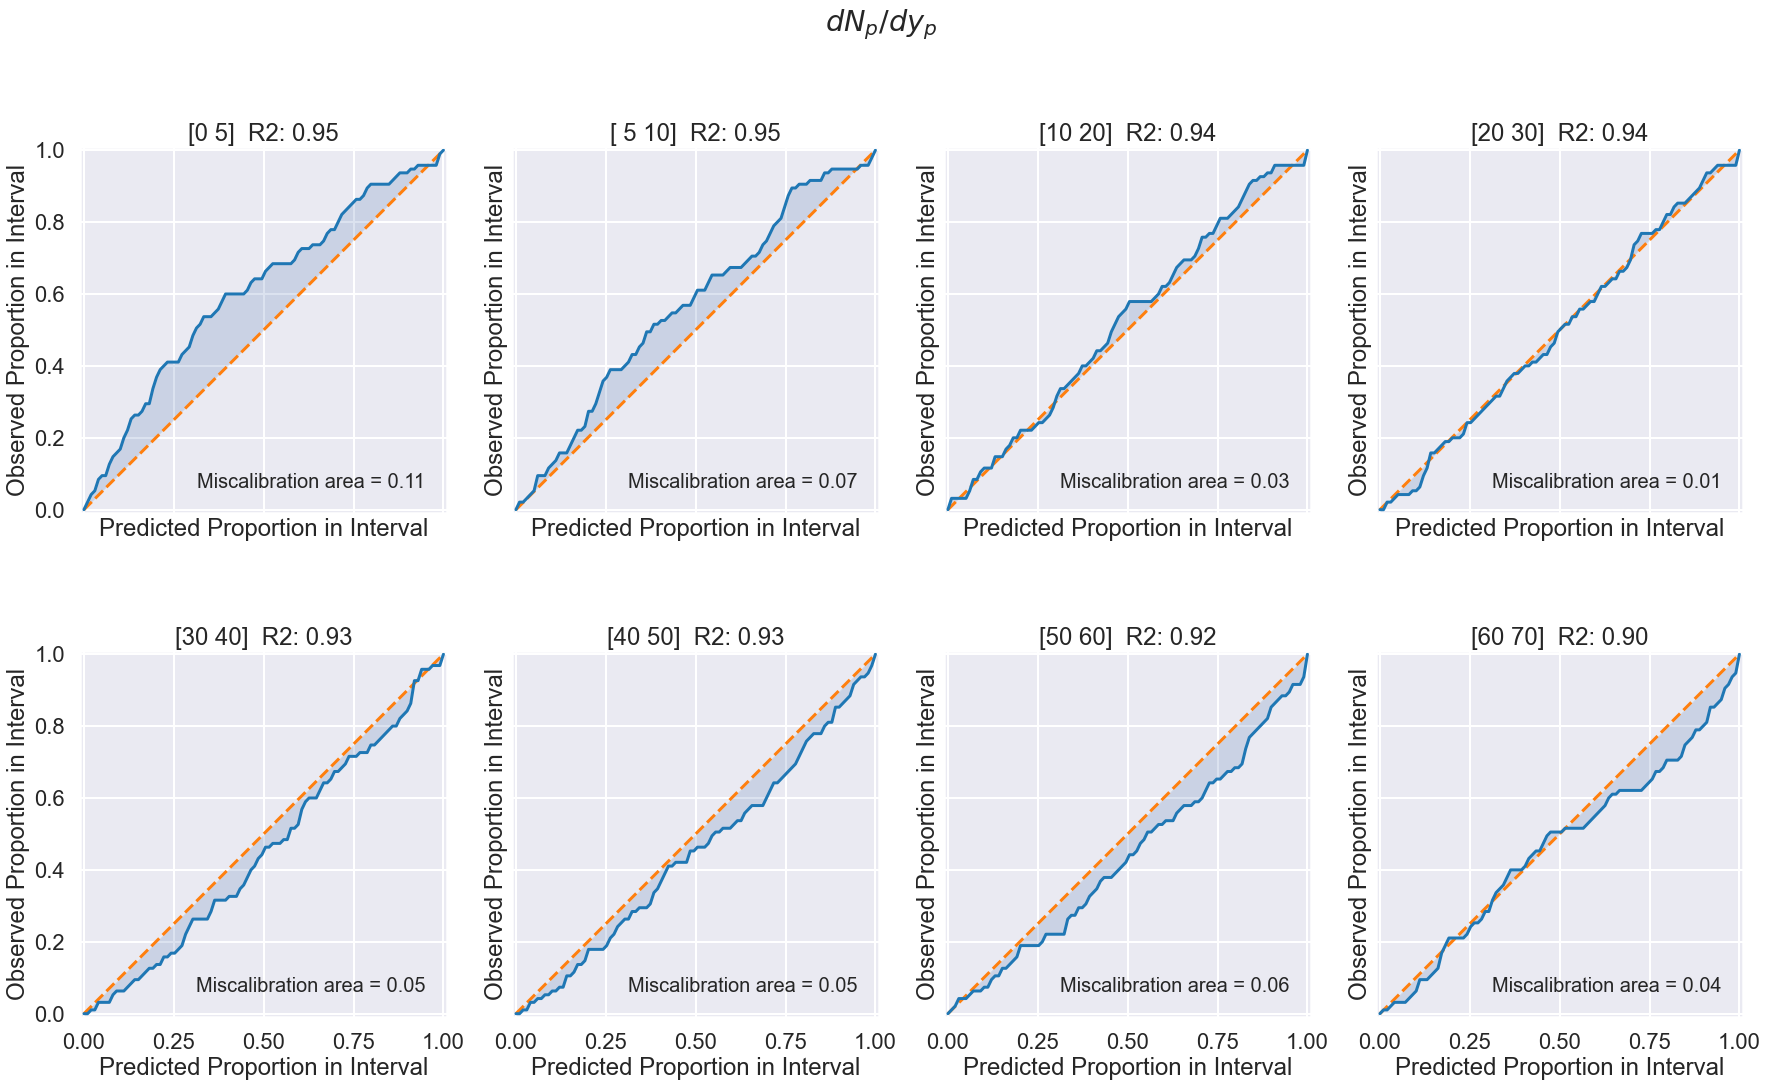

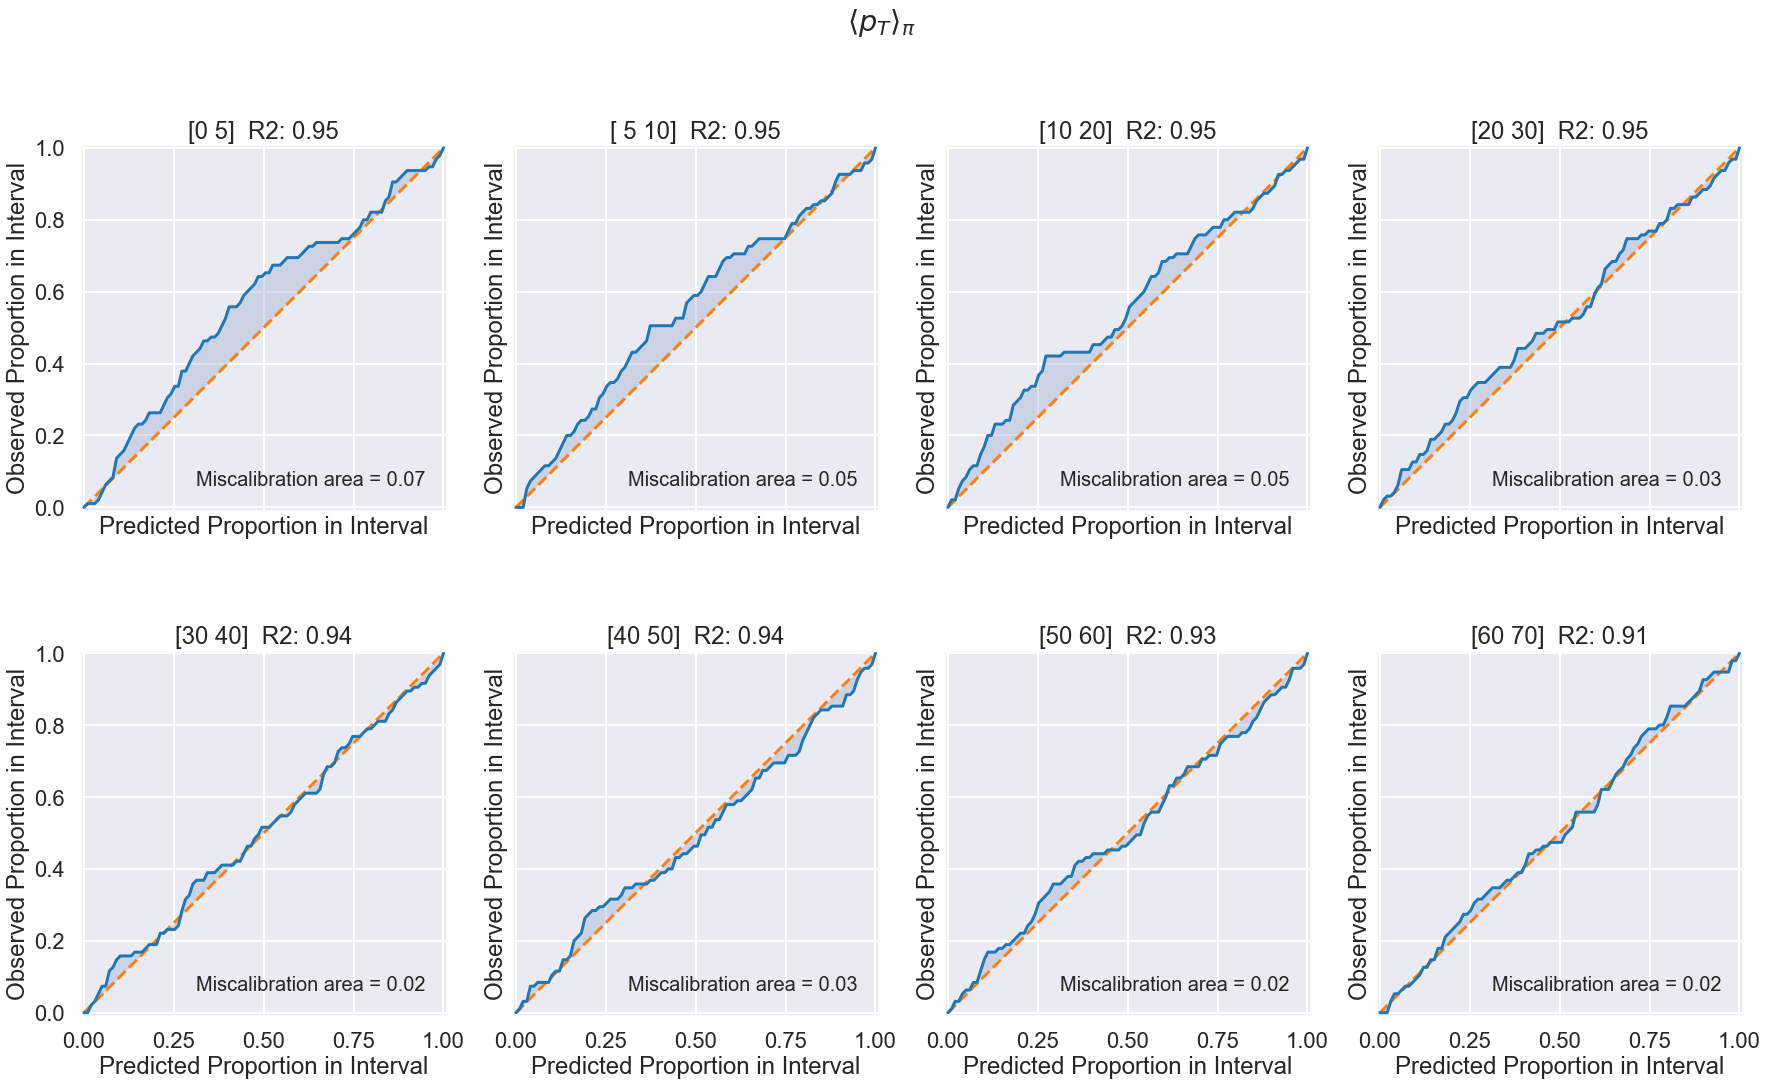

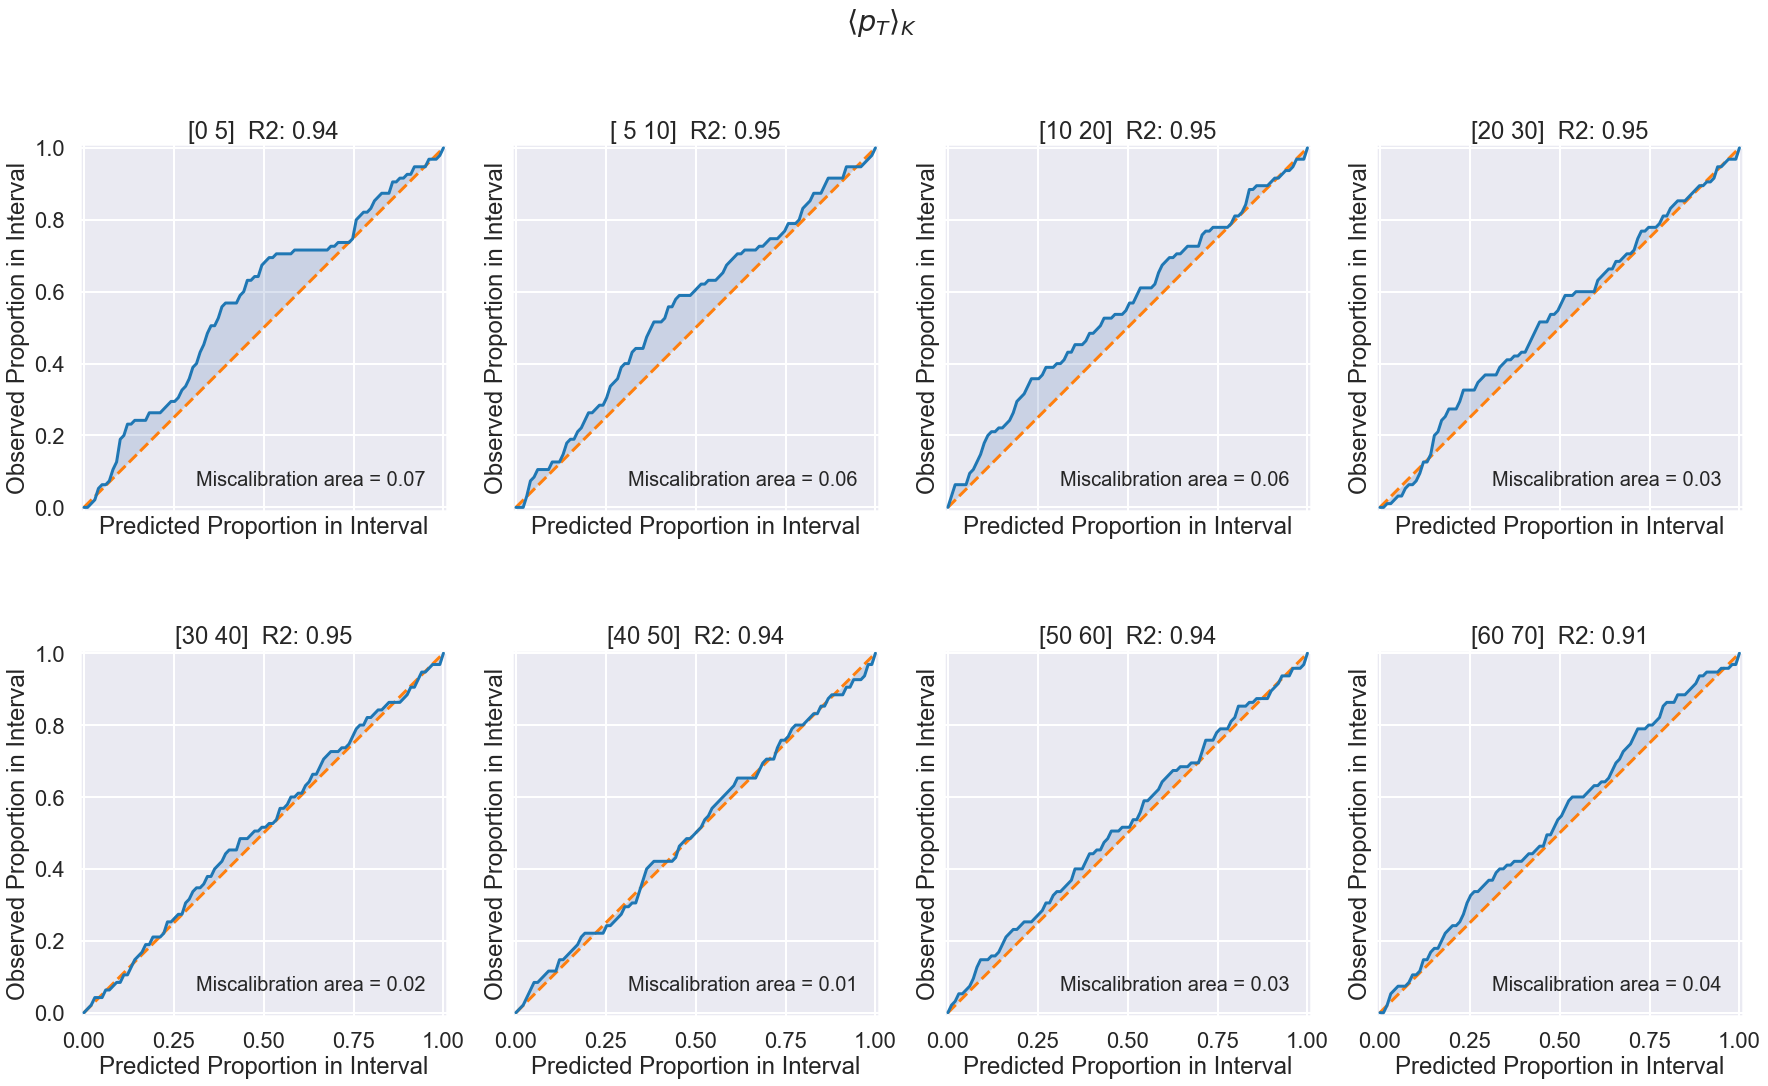

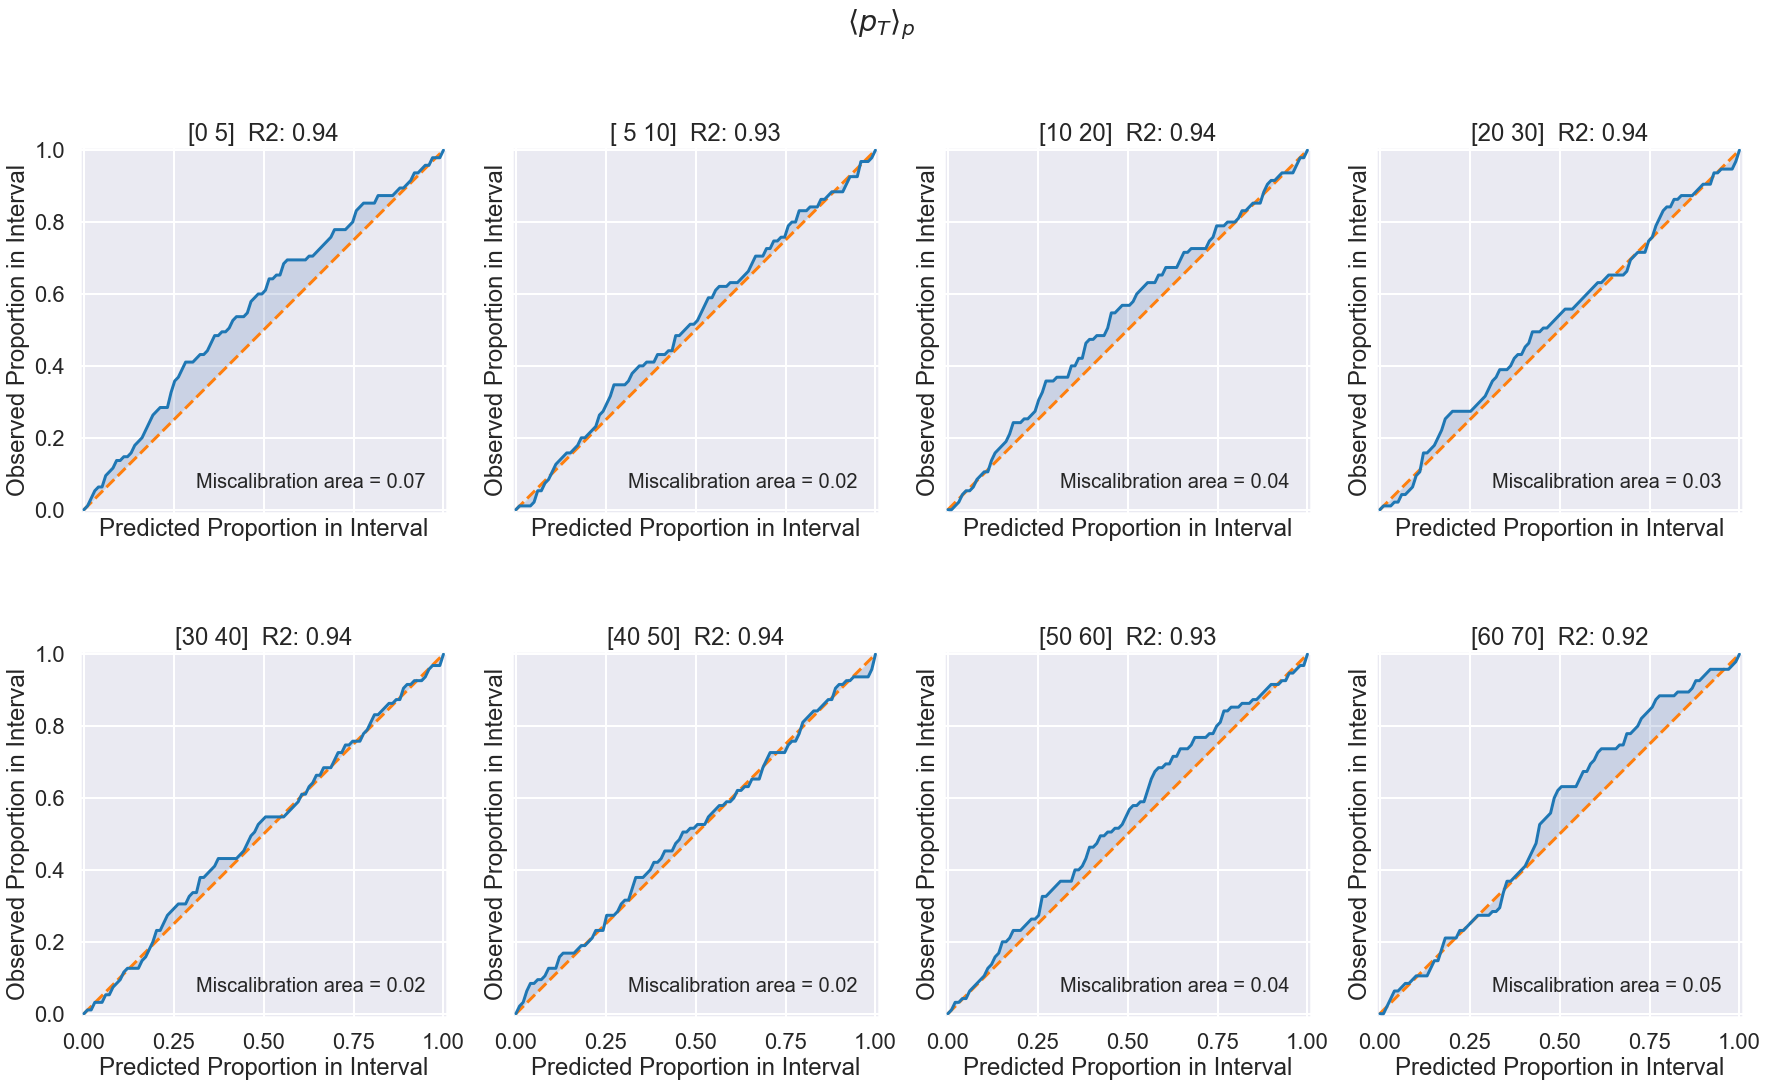

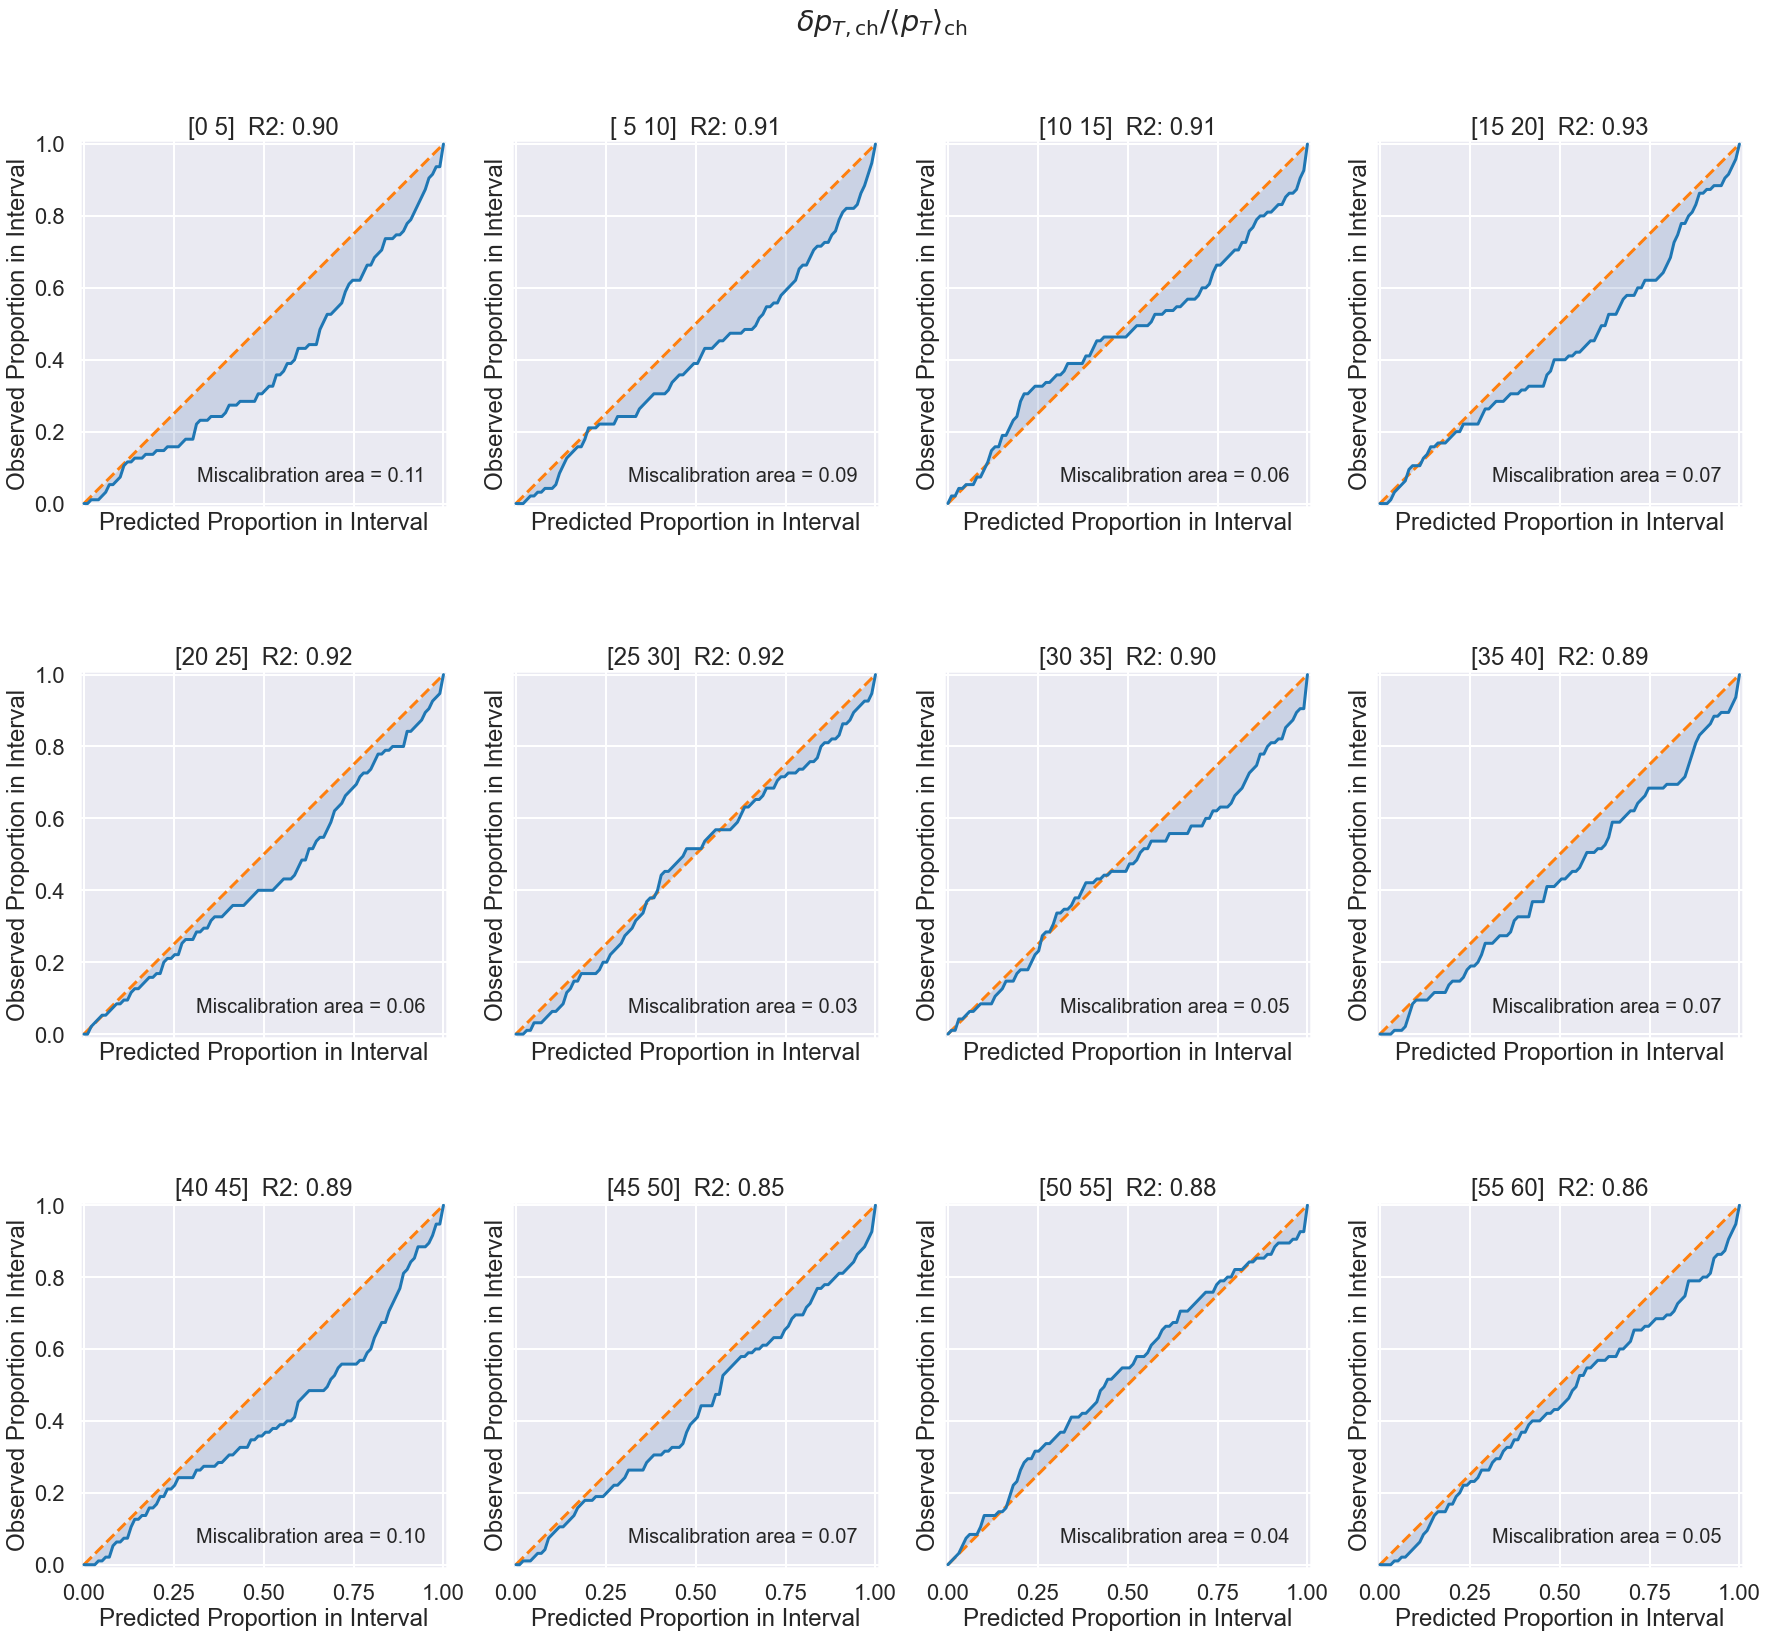

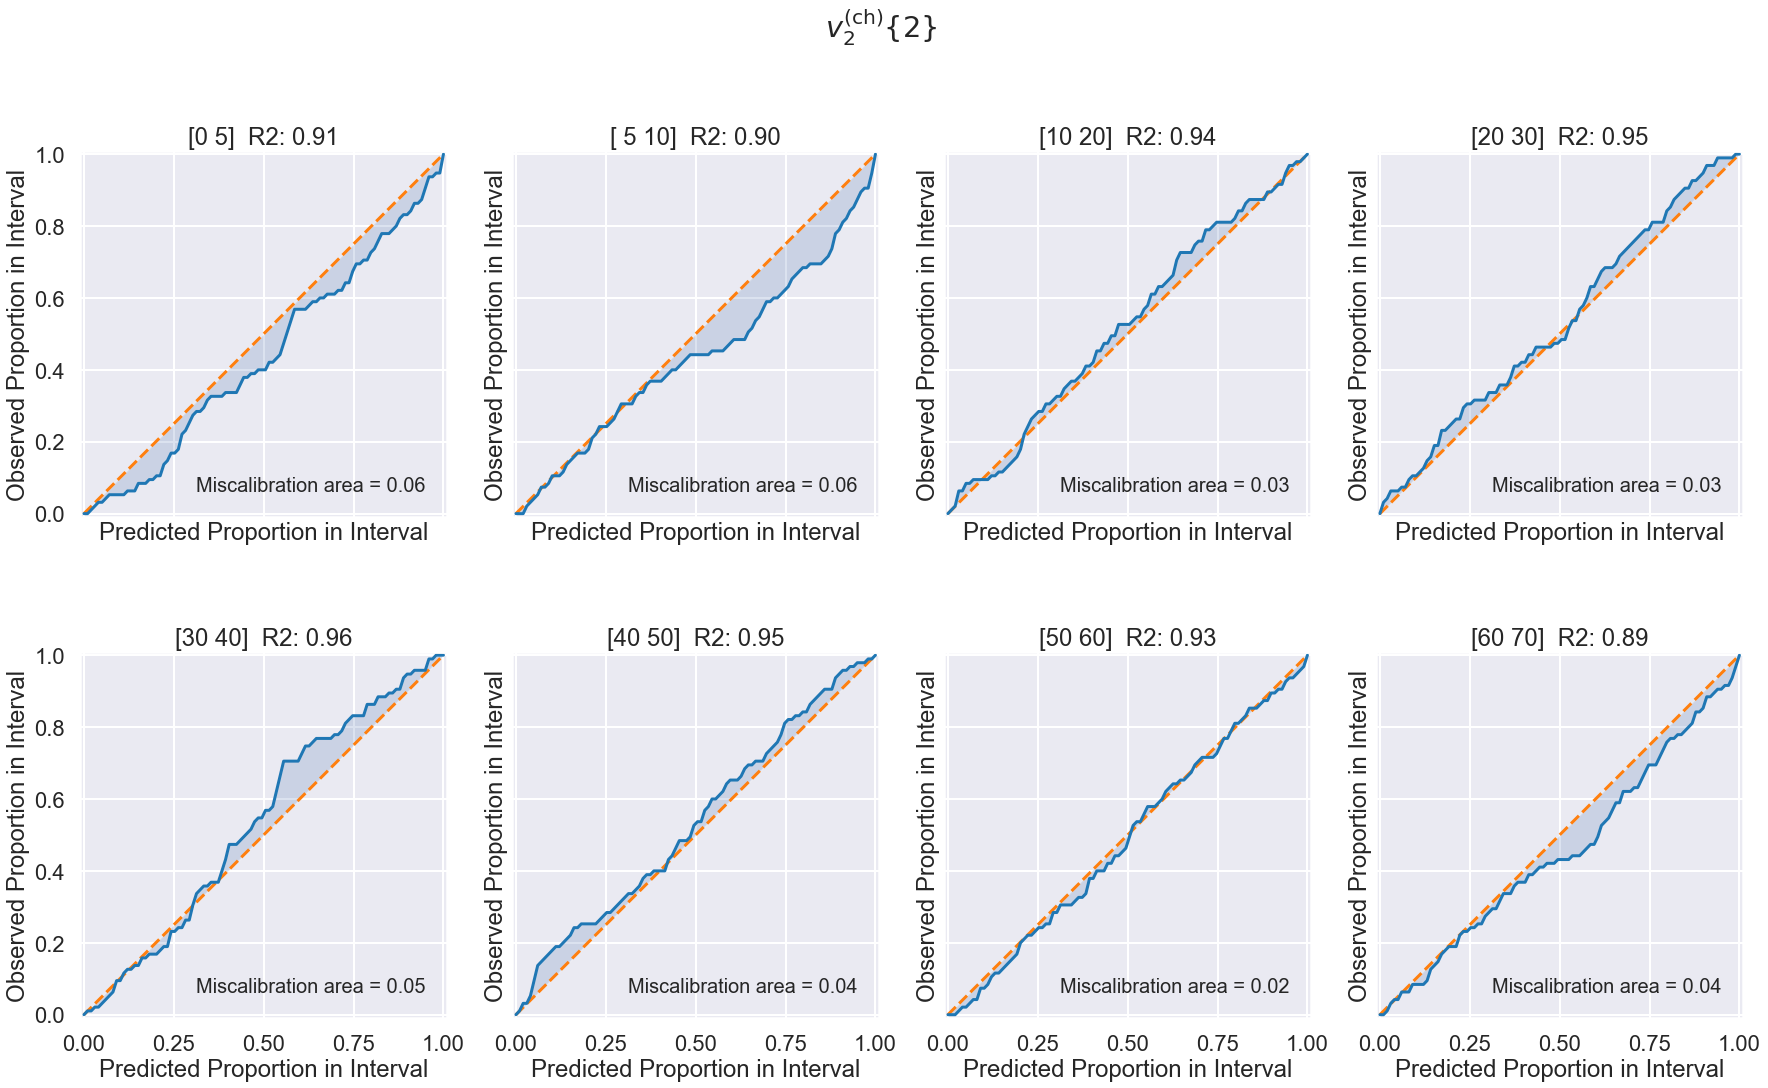

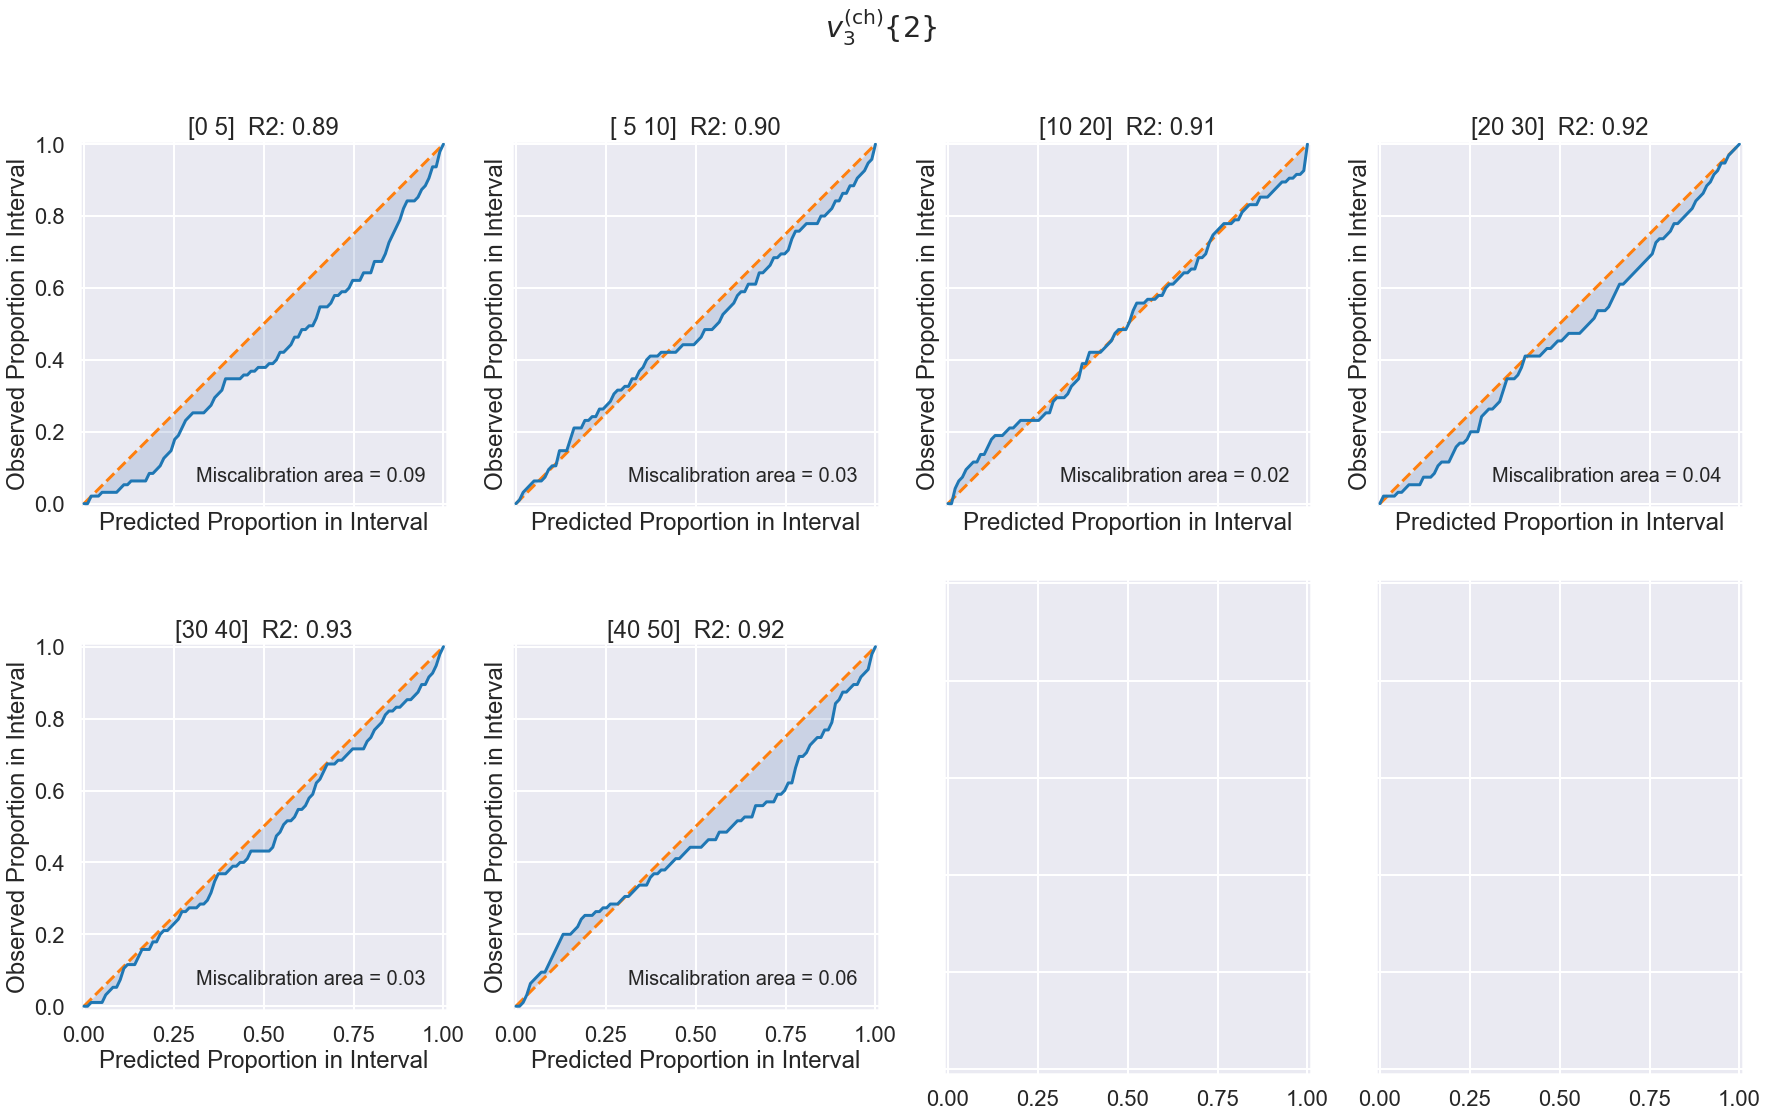

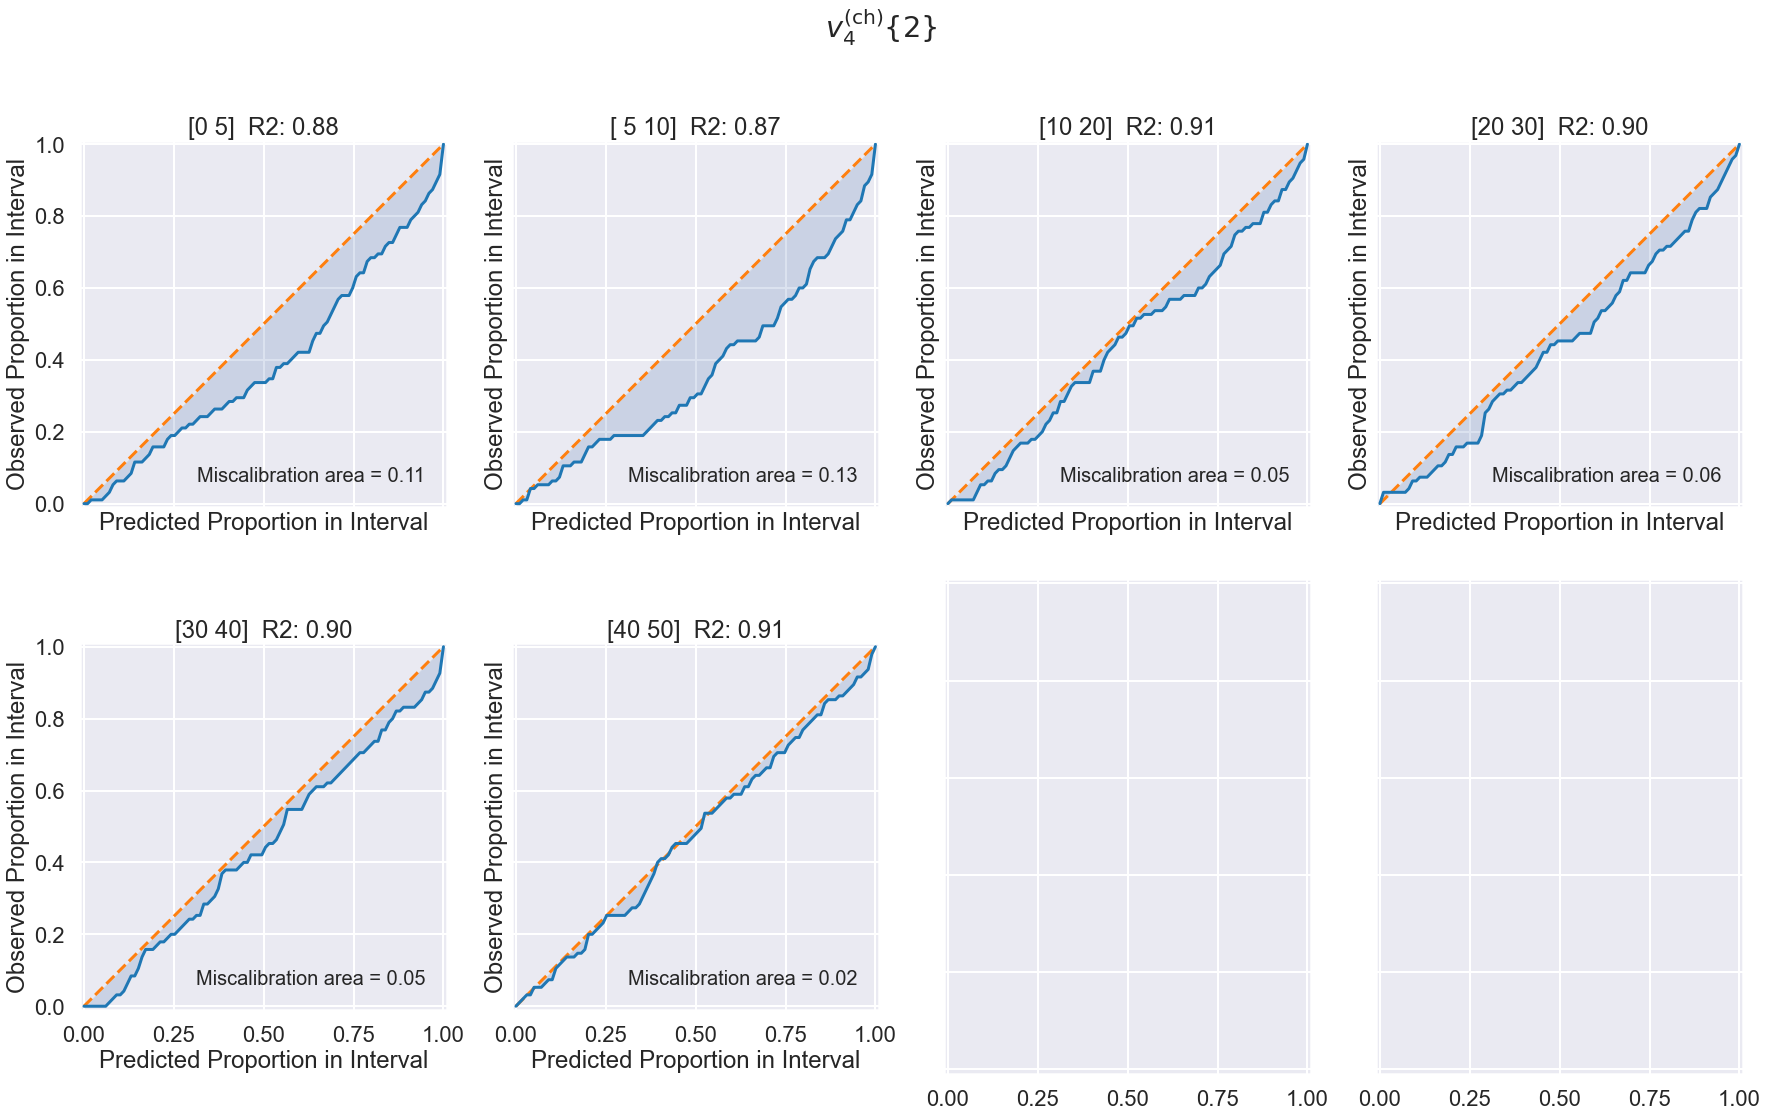

In [29]:
sns.set_context('poster')
for obs in index.keys():
    st = index[obs][0]
    ed = index[obs][1]
    nrw = int(np.ceil((ed-st)/4))
    fig, axs = plt.subplots(nrows=nrw,ncols= 4, figsize=(25,nrw*8),sharex=True, sharey=True)
    for iii,ax in enumerate(axs.flatten()):
        if iii>=ed-st:
            continue;
        ii=st+iii
        mse = sklearn.metrics.mean_squared_error(Y_test[:,ii]\
                                       ,prediction_val[:,ii])
        r = sklearn.metrics.r2_score(Y_test[:,ii]\
                                       ,prediction_val[:,ii])
        #print(r)
        uct.plot_calibration(prediction_val[:,ii], prediction_sig_val[:,ii], Y_test[:,ii], ax=ax)
        cen_st = obs_cent_list['Pb-Pb-2760'][obs][iii]
        #print(cen_st)
        ax.set_title(f'{cen_st}  R2: {r:.2f}')
    fig.suptitle(obs_tex_labels[obs])
    plt.tight_layout()
    #save_fig(f'{obs}_calibration_curve.png')